In [1]:
from spotlight.interactions import Interactions
from spotlight.cross_validation import random_train_test_split, user_based_train_test_split
from spotlight.factorization.explicit import ExplicitFactorizationModel
from spotlight.factorization.implicit import ImplicitFactorizationModel
from spotlight.evaluation import rmse_score, mrr_score, precision_recall_score, sequence_mrr_score, sequence_precision_recall_score
import numpy as np
import pandas
from functools import partial
from pathlib import Path
from tqdm import tqdm
from spotlight.sequence.implicit import ImplicitSequenceModel
import matplotlib.pyplot as plt

In [2]:
RATINGS_PATH = Path('private/ml-100k/u.data')
BEST_OF = 50
RANDOM_STATE = 42
ITERATIONS = 50
REPEAT = 10

In [3]:
ratings_df = pandas.read_csv(RATINGS_PATH, sep='\t', header=0, names=['UserID', 'MovieID', 'Rating', 'Timestamp'])

In [4]:
ratings_test_df  = ratings_df.sort_values('Timestamp').groupby('UserID').tail(1)

In [5]:
ratings_train_df = pandas.concat([ratings_df, ratings_test_df]).drop_duplicates(keep=False)

In [6]:
len(ratings_train_df) + len(ratings_test_df) == len(ratings_df)

True

In [7]:
interactions = Interactions(
    user_ids=ratings_train_df['UserID'].to_numpy(dtype=np.int32),
    item_ids=ratings_train_df['MovieID'].to_numpy(dtype=np.int32),
    ratings=ratings_train_df['Rating'].to_numpy(dtype=np.float32),
    timestamps=ratings_train_df['Timestamp'].to_numpy(dtype=np.int32)
)

In [8]:
train = interactions

In [9]:
test_list = list(ratings_test_df[['UserID', 'MovieID']].merge(ratings_train_df[['UserID', 'MovieID']].groupby('UserID')['MovieID'].apply(list).reset_index(name='MovieIDs'))[['UserID','MovieIDs', 'MovieID']].to_records(index=False))

In [13]:
def factorization_test(model, test_data):
    h_top = 0
    for user, movies, movie in test_data:
        items = model.predict(user)
        new_items = np.delete(items, movies)
        top_items = np.argpartition(new_items, -BEST_OF)[-BEST_OF:]
        
        if movie in top_items:
            h_top += 1
    h_top = h_top / len(test_data) 
    # print(f"h_top: {h_top}")
    return h_top

def sequential_test(model, test_data):
    h_top = 0
    for user, movies, movie in test_data:
        items = model.predict(movies)
        new_items = np.delete(items, movies)
        top_items = np.argpartition(items, -BEST_OF)[-BEST_OF:]
        
        
        if movie in top_items:
            h_top += 1
    h_top = h_top / len(test_data) 
    # print(f"h_top: {h_top}")
    return h_top

def train_test(model_const, iterations, train_data ,test_data, repeat, is_fac = True):
    results = []
    model = model_const()
    for __ in range(repeat):
        for ii in range(iterations):
            model.fit(train_data)
            if is_fac:
                ft = factorization_test(model, test_data)
            else:
                ft = sequential_test(model, test_data)
            results.append((ii+1,ft))
    
    results = np.array(results)
    results_pd = pandas.DataFrame(results, columns=['iteration', 'hit_rate']).groupby('iteration').agg(["mean", "std"])
    plt.plot(results_pd[('hit_rate','mean')])
    plt.xlabel('iterations')
    plt.ylabel('hit_rate')
    plt.fill_between(results_pd.index, results_pd[('hit_rate','mean')] + results_pd[('hit_rate','std')], results_pd[('hit_rate','mean')] - results_pd[('hit_rate','std')], color='b', alpha=0.2)
    plt.show()
    print('Max hit_rate ', results_pd[('hit_rate','mean')].max())
    return (results_pd, model)

## ExplicitFactorizationModel

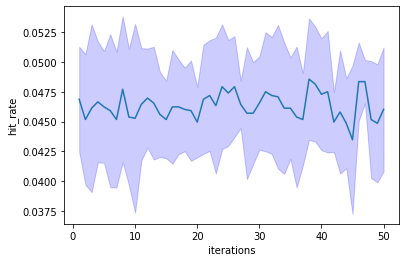

Max hit_rate  0.04856839872746553


In [14]:
ef_model = partial(ExplicitFactorizationModel,n_iter=1, use_cuda=True)
x = train_test(ef_model, ITERATIONS, train, test_list, REPEAT)

## ImplicitFactorizationModel

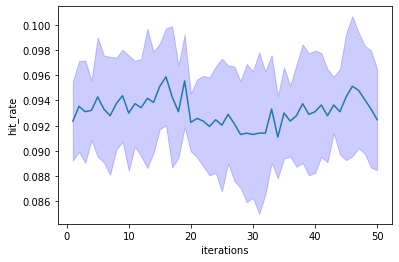

Max hit_rate  0.09586426299045599


In [15]:
if_model = partial(ImplicitFactorizationModel,n_iter=1, use_cuda=True)
x = train_test(if_model, ITERATIONS, train, test_list, REPEAT)

## Sequence models

### Pooling

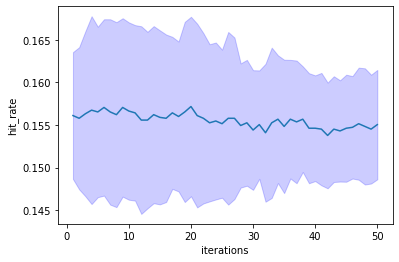

Max hit_rate  0.15715800636267233


In [16]:
seq_pool_model = partial(ImplicitSequenceModel,n_iter=1, representation='pooling', use_cuda=True)
x = train_test(seq_pool_model, ITERATIONS, train.to_sequence(), test_list, REPEAT, False)

### LSTM

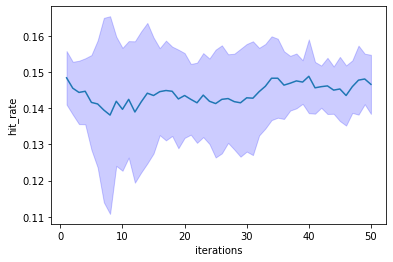

Max hit_rate  0.14878048780487801


In [17]:
seq_lstm_model = partial(ImplicitSequenceModel,n_iter=1, representation='lstm', use_cuda=True)
x = train_test(seq_lstm_model, ITERATIONS, train.to_sequence(), test_list, REPEAT, False)

In [ ]:
seq_cnn_model = partial(ImplicitSequenceModel,n_iter=1, representation='cnn', use_cuda=True)
x = train_test(seq_cnn_model, ITERATIONS, train.to_sequence(), test_list, REPEAT, False)

## CNN

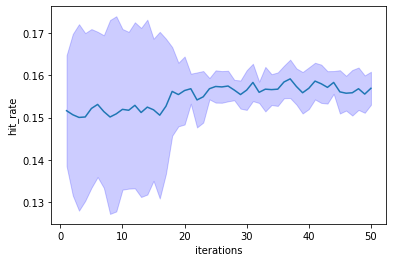

Max hit_rate  0.1591728525980912


In [18]:
seq_cnn_model = partial(ImplicitSequenceModel,n_iter=1, representation='cnn', use_cuda=True)
x = train_test(seq_cnn_model, ITERATIONS, train.to_sequence(), test_list, REPEAT, False)

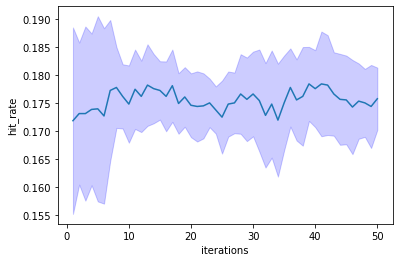

Max hit_rate  0.1784729586426299


In [21]:
seq_cnn_model = partial(ImplicitSequenceModel,n_iter=1, representation='cnn', use_cuda=True, loss='bpr')
x = train_test(seq_cnn_model, ITERATIONS, train.to_sequence(), test_list, REPEAT, False)

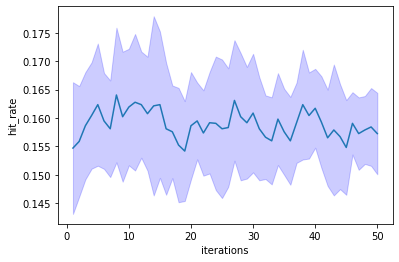

Max hit_rate  0.164050901378579


In [22]:
seq_cnn_model = partial(ImplicitSequenceModel,n_iter=1, representation='cnn', use_cuda=True, loss='hinge')
x = train_test(seq_cnn_model, ITERATIONS, train.to_sequence(), test_list, REPEAT, False)

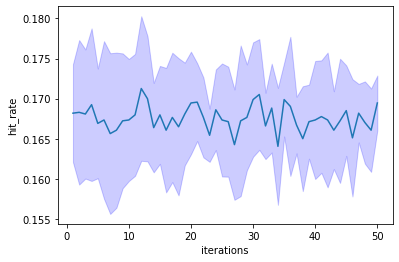

Max hit_rate  0.17126193001060444


In [23]:
seq_cnn_model = partial(ImplicitSequenceModel,n_iter=1, representation='cnn', use_cuda=True, loss='adaptive_hinge')
x = train_test(seq_cnn_model, ITERATIONS, train.to_sequence(), test_list, REPEAT, False)